In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter


from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
# Load the data
file_path = Path('../Data/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [6]:
# Create our features
X = df.copy()
X.drop("loan_status", axis=1, inplace=True)

# Create our target
y = df["loan_status"]

In [7]:
X.describe(include='all')

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,dti,delinq_2yrs,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
count,68817.000000,68817.000000,68817.000000,68817,6.881700e+04,68817,68817,68817,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04,68817,68817
unique,NaN,NaN,NaN,4,NaN,3,3,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
top,NaN,NaN,NaN,MORTGAGE,NaN,Not Verified,Jan-2019,n,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N
freq,NaN,NaN,NaN,36219,NaN,32895,31041,68817,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68817,68817
mean,16677.594562,0.127718,480.652863,NaN,8.821371e+04,NaN,NaN,NaN,21.778153,0.217766,...,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04,NaN,NaN
std,10277.348590,0.048130,288.062432,NaN,1.155800e+05,NaN,NaN,NaN,20.199244,0.718367,...,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04,NaN,NaN
min,1000.000000,0.060000,30.890000,NaN,4.000000e+01,NaN,NaN,NaN,0.000000,0.000000,...,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02,NaN,NaN
25%,9000.000000,0.088100,265.730000,NaN,5.000000e+04,NaN,NaN,NaN,13.890000,0.000000,...,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04,NaN,NaN
50%,15000.000000,0.118000,404.560000,NaN,7.300000e+04,NaN,NaN,NaN,19.760000,0.000000,...,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04,NaN,NaN
75%,24000.000000,0.155700,648.100000,NaN,1.040000e+05,NaN,NaN,NaN,26.660000,0.000000,...,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04,NaN,NaN


In [8]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [9]:
# Identify catogorical data
df.select_dtypes(include='object').head(10)

,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,initial_list_status,next_pymnt_d,application_type,hardship_flag,debt_settlement_flag
0,RENT,Source Verified,Mar-2019,low_risk,n,w,May-2019,Individual,N,N
1,MORTGAGE,Verified,Mar-2019,low_risk,n,w,May-2019,Individual,N,N
2,MORTGAGE,Verified,Mar-2019,low_risk,n,w,May-2019,Individual,N,N
3,RENT,Verified,Mar-2019,low_risk,n,w,May-2019,Individual,N,N
4,MORTGAGE,Not Verified,Mar-2019,low_risk,n,w,May-2019,Individual,N,N
5,MORTGAGE,Source Verified,Mar-2019,low_risk,n,w,May-2019,Individual,N,N
6,RENT,Source Verified,Mar-2019,low_risk,n,w,May-2019,Individual,N,N
7,OWN,Source Verified,Mar-2019,low_risk,n,w,May-2019,Individual,N,N
8,RENT,Not Verified,Mar-2019,low_risk,n,f,May-2019,Individual,N,N
9,RENT,Verified,Mar-2019,low_risk,n,w,May-2019,Individual,N,N


In [10]:
X = pd.get_dummies(X, columns=["home_ownership", "verification_status", "issue_d", 
                               "pymnt_plan","initial_list_status", "next_pymnt_d", 
                               "application_type", "hardship_flag", "debt_settlement_flag"])

X.head(10)

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,1,1,0,1,0,1,1,0,1,1
5,25000.0,0.1797,634.43,90000.0,18.49,1.0,1.0,14.0,0.0,23889.0,...,1,1,0,1,0,1,1,0,1,1
6,20400.0,0.2000,540.48,51315.0,25.63,0.0,2.0,8.0,1.0,2569.0,...,1,1,0,1,0,1,1,0,1,1
7,10000.0,0.1557,349.46,66000.0,9.00,0.0,0.0,11.0,0.0,9407.0,...,1,1,0,1,0,1,1,0,1,1
8,14000.0,0.0881,443.96,45000.0,10.24,0.0,1.0,9.0,0.0,7058.0,...,1,1,1,0,0,1,1,0,1,1
9,10000.0,0.1474,345.39,63295.0,39.34,0.0,0.0,27.0,0.0,25790.0,...,1,1,0,1,0,1,1,0,1,1


In [11]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [320]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [321]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [322]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [323]:
# Scale the training data - only scale X_train and X_test data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [324]:
# Resample the training data with the RandomOversampler
# fit Random Forest Classifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                               criterion='gini', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               max_samples=None, min_impurity_decrease=0.0,
                               min_samples_leaf=2, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_jobs=None, oob_score=False, random_state=42,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [325]:
y_pred = brf.predict(X_test_scaled)

balanced_accuracy_score(y_test, y_pred)

0.748956988570169

In [326]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.748956988570169

In [327]:
# Display the confusion matrix
print("Confusion Matrix - Balanced Random Forest")
confusion_matrix(y_test, y_pred)

Confusion Matrix - Balanced Random Forest


array([[   62,    42],
       [ 1680, 15421]])

In [328]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print("Classification Report - Balanced Random Forest on Imbalanced Data")
print(classification_report_imbalanced(y_test, y_pred))

Classification Report - Balanced Random Forest on Imbalanced Data
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.60      0.90      0.07      0.73      0.52       104
   low_risk       1.00      0.90      0.60      0.95      0.73      0.55     17101

avg / total       0.99      0.90      0.60      0.94      0.73      0.55     17205



In [329]:
# List the features sorted in descending order by feature importance

# Random Forests in sklearn will automatically calculate feature importance
importances = brf.feature_importances_

# We can sort the features by their importance
sorted(zip(brf.feature_importances_, X.columns), reverse=True)

[(0.08137613053153643, 'total_rec_prncp'),
 (0.07480763771325438, 'total_pymnt_inv'),
 (0.06897747174185792, 'total_rec_int'),
 (0.06290530816366714, 'total_pymnt'),
 (0.04653618740031736, 'last_pymnt_amnt'),
 (0.030820280180206706, 'int_rate'),
 (0.020040474412645278, 'issue_d_Jan-2019'),
 (0.01698362347785105, 'max_bal_bc'),
 (0.016431351159852236, 'total_bal_ex_mort'),
 (0.01609199597682265, 'total_bc_limit'),
 (0.01607760120380155, 'revol_bal'),
 (0.015571671887419432, 'installment'),
 (0.015137104997311562, 'out_prncp'),
 (0.015065352205913166, 'total_rev_hi_lim'),
 (0.014592884679946834, 'dti'),
 (0.014549666423813924, 'issue_d_Mar-2019'),
 (0.01440618264358756, 'il_util'),
 (0.014033855377281777, 'bc_util'),
 (0.013734448127793534, 'mo_sin_old_rev_tl_op'),
 (0.013576090843893066, 'out_prncp_inv'),
 (0.01354447321433759, 'tot_hi_cred_lim'),
 (0.013529727162074665, 'mths_since_rcnt_il'),
 (0.012983884198302851, 'annual_inc'),
 (0.01293938193263122, 'all_util'),
 (0.012830386546762

### Easy Ensemble AdaBoost Classifier

In [330]:
# Train the Classifier
# fit Random Forest Classifier

from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_estimators=100, random_state=42)
eec.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(base_estimator=None, n_estimators=100, n_jobs=None,
                       random_state=42, replacement=False,
                       sampling_strategy='auto', verbose=0, warm_start=False)

In [331]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test_scaled)

balanced_accuracy_score(y_test, y_pred)

0.933294499197078

In [332]:
# Display the confusion matrix
print("Confusion Matrix - Easy Emsemble AdaBoost")
confusion_matrix(y_test, y_pred)

Confusion Matrix - Easy Emsemble AdaBoost


array([[   96,     8],
       [  966, 16135]])

In [333]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print("Classification Report - Easy Ensemble AdaBoost on Imbalanced Data")
print(classification_report_imbalanced(y_test, y_pred))

Classification Report - Easy Ensemble AdaBoost on Imbalanced Data
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.92      0.94      0.16      0.93      0.87       104
   low_risk       1.00      0.94      0.92      0.97      0.93      0.87     17101

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205



# Gradient Boosting Classifier 
## _*Additional Model*_

In [334]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    classifier = GradientBoostingClassifier(n_estimators=20,
                                            learning_rate=learning_rate,
                                            max_features=5,
                                            max_depth=3,
                                            random_state=0)

    # Fit the model
    classifier.fit(X_train_scaled, y_train.ravel())
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        classifier.score(
            X_train_scaled,
            y_train.ravel())))
    print("Accuracy score (validation): {0:.3f}".format(
        classifier.score(
            X_test_scaled,
            y_test.ravel())))
    print()

Learning rate:  0.05
Accuracy score (training): 0.996
Accuracy score (validation): 0.995

Learning rate:  0.1
Accuracy score (training): 0.997
Accuracy score (validation): 0.995

Learning rate:  0.25
Accuracy score (training): 0.995
Accuracy score (validation): 0.993

Learning rate:  0.5
Accuracy score (training): 0.995
Accuracy score (validation): 0.994

Learning rate:  0.75
Accuracy score (training): 0.994
Accuracy score (validation): 0.993

Learning rate:  1
Accuracy score (training): 0.995
Accuracy score (validation): 0.993



In [335]:
# Choose a learning rate and create classifier
# Use learning_rate of 0.1 for its higher training and testing scores compared to the rest

classifier = GradientBoostingClassifier(n_estimators=20,
                                        learning_rate=0.1,
                                        max_features=5,
                                        max_depth=3,
                                        random_state=0)

# Fit the model
classifier.fit(X_train_scaled, y_train.ravel())

# Make Prediction
predictions = classifier.predict(X_test_scaled)
pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(20)

,Prediction,Actual
0,low_risk,low_risk
1,low_risk,low_risk
2,low_risk,low_risk
3,low_risk,low_risk
4,low_risk,low_risk
5,low_risk,low_risk
6,low_risk,low_risk
7,low_risk,low_risk
8,low_risk,low_risk
9,low_risk,low_risk


In [336]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.994768962510898


In [337]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
print("Confusion Matrix - Gradient Boosting")
display(cm_df)

Confusion Matrix - Gradient Boosting


,Predicted 0,Predicted 1
Actual 0,30,74
Actual 1,16,17085


In [338]:
# Generate classification report
print("Classification Report - Gradient Boosting on Imbalanced Data")
print(classification_report_imbalanced(y_test, predictions))

Classification Report - Gradient Boosting on Imbalanced Data
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.65      0.29      1.00      0.40      0.54      0.27       104
   low_risk       1.00      1.00      0.29      1.00      0.54      0.31     17101

avg / total       0.99      0.99      0.29      0.99      0.54      0.31     17205



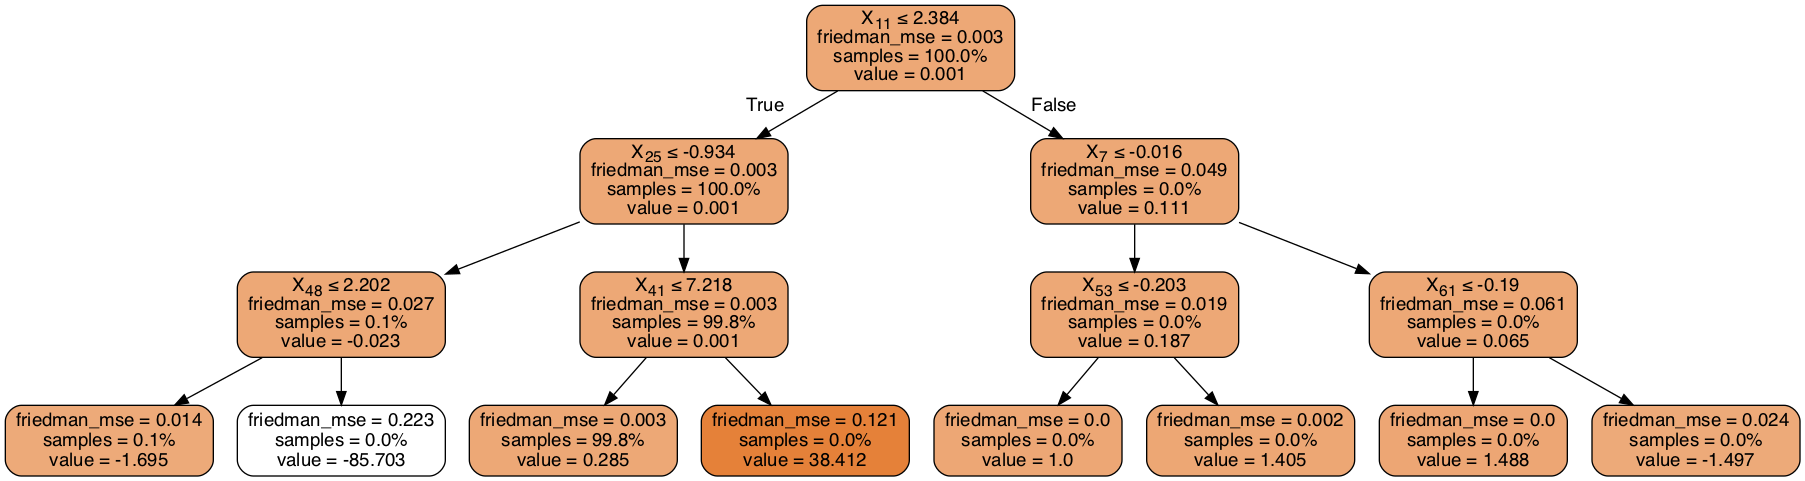

In [339]:
# Graph tree
from sklearn import tree

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

dot_data = tree.export_graphviz(
    classifier.estimators_[12, 0],
    out_file=None, filled=True,
    rounded=True,
    special_characters=True,
    proportion=True,
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [340]:
# Saving the tree as PDF
graph.write_pdf("../Images/GradientBoosting_tree.pdf")

# Saving the tree as PNG
graph.write_png("../Images/GradientBoosting_tree.png")


True

### Precision-Recall Curve on Random Forest and Easy Ensemble AdaBoost 
#### _*Note: `1` represents `low_risk` and `0` represents `high_risk` for y*_

In [12]:
# Redefine y
y = pd.get_dummies(y)['high_risk']

In [13]:
# Create X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [20]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [21]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [22]:
# Scale the training data - only scale X_train and X_test data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#### _*Re-train Models for Random Forest and Easy Ensemble AdaBoost*_

In [23]:
# Resample the training data with the RandomOversampler
# fit Random Forest Classifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                               criterion='gini', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               max_samples=None, min_impurity_decrease=0.0,
                               min_samples_leaf=2, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_jobs=None, oob_score=False, random_state=42,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [26]:
# Train the Classifier
# fit Random Forest Classifier

from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_estimators=100, random_state=42)
eec.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(base_estimator=None, n_estimators=100, n_jobs=None,
                       random_state=42, replacement=False,
                       sampling_strategy='auto', verbose=0, warm_start=False)

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

# Choose a learning rate and create classifier
# Use learning_rate of 0.1 for its higher training and testing scores compared to the rest

classifier = GradientBoostingClassifier(n_estimators=20,
                                        learning_rate=0.1,
                                        max_features=5,
                                        max_depth=3,
                                        random_state=0)

# Fit the model
classifier.fit(X_train_scaled, y_train.ravel())

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=5, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [36]:
# Plot the Precision Recall Curvey for both the SMOTEENN + Logistic Regression model
# and the Balanced Random Forest model
from sklearn.metrics import precision_recall_curve

probs_brf = brf.predict_proba(X_test_scaled)[:, 1]
probs_eec = eec.predict_proba(X_test_scaled)[:, 1]
probs_grad = classifier.predict_proba(X_test_scaled)[:, 1]

precision_brf, recall_brf, _ = precision_recall_curve(y_test, probs_brf, pos_label=1)
precision_eec, recall_eec, _ = precision_recall_curve(y_test, probs_eec, pos_label=1)
precision_grad, recall_grad, _ = precision_recall_curve(y_test, probs_grad, pos_label=1)

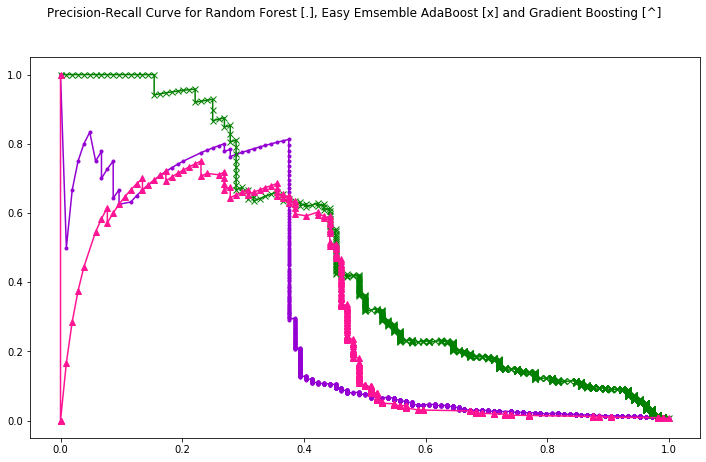

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,7))

plt.plot(recall_brf, precision_brf, marker='.', color='darkviolet')
plt.plot(recall_eec, precision_eec, marker='x', color='green')
plt.plot(recall_grad, precision_grad, marker='^', color='deeppink')

plt.suptitle('Precision-Recall Curve for Random Forest [.], Easy Emsemble AdaBoost [x] and Gradient Boosting [^]')
plt.show()

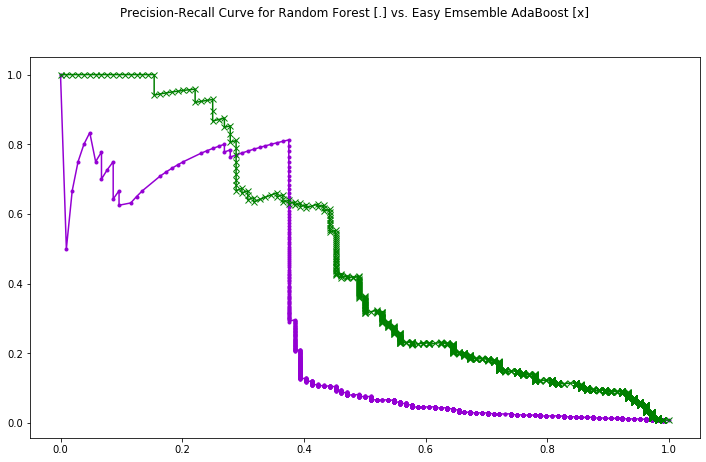

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,7))

plt.plot(recall_brf, precision_brf, marker='.', color='darkviolet')
plt.plot(recall_eec, precision_eec, marker='x', color='green')
#plt.plot(recall_grad, precision_grad, marker='^')

plt.suptitle('Precision-Recall Curve for Random Forest [.] vs. Easy Emsemble AdaBoost [x]')
plt.show()